# L-layer network. 

* We will work on classifying cat pictures with L layers of neural network 
* First, we will write some function that will help make the complete model 
* Broadly, we will follow the steps below: 
    - Initialize parameters for all layers 
    - Forward propagation for Linear -> ReLu layers, i.e. from layer 1 to laye L-1
    - Forward propagation for Linear -> Sigmoid layers, i.e. for layer L.
    - Compute cost function(cross entropy loss)
    - Backward propagation for Linear -> Sigmoid layer L.
    - Backward propagation for Linear -> ReLu layers, i.e. from L-1 to 1.
    - we update parameter at each step during this process 

 * We will be using following function for this work 
     - Initilaize_parameters 
     - L_model_forward 
     - Compute_cost 
     - L_model_backward 
     - Update_parameters 
     - sigmoid 
     - Relu 
     - Sigmoid_backward 
     - ReLu_backward

In [1]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
import h5py
np.random.seed(1)

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# Activation functions for different layers 

## Relu and its back prop implementation 

def relu(Z):
    """
    Implement ReLu activation fucntion 
    
    Argument: 
    Z : array of matrix 
    
    Return : 
    A : a rectified linear unit output. 
    Activation_cache : cached value of Z in a dictionary, that will be used during back propagation 
    """
    A = np.maximum(0, Z) 
    
    assert(A.shape == Z.shape)
    
    cache = Z
    return A, cache

def relu_backward(dA, cache):
    """
    Implement relu backward for single unit 
    
    Arguments: 
    dA : 
    cache : 
    
    Returns: 
    dZ : drivative of the relu function 
    """
    
    Z = cache 
    dZ = np.array(dA, copy=True)
    
    # for relu, we only need to take care of the less than zero terms and set them to zero 
    dZ[Z<=0] = 0
    assert(dZ.shape == Z.shape)
    
    return dZ

# sigmoid and its backprop implementation

def sigmoid(Z): 
    """
    Implement sigmoid function on array. 
    
    Argument: 
    Z : weighted input array before activation 
    
    Returns: 
    A : activation value A after application of sigmoid. 
    cache : value of Z, cached for effective calculation during back propagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def sigmoid_backward(dA, cache): 
    """
    Implement derivative of sigmoid. 
    
    Arguments: 
    A : post active gradient of any shape 
    Cache : value Z cached during sigmoid calculation
    
    Returns : 
    Z : derivative of sigmoid, here it will return derivative of Cost.
    """
    
    Z = cache 
    sigmoid = 1/ (1 + np.exp(-Z))
    dZ = dA*sigmoid*(1-sigmoid)
    
    assert(dZ.shape == Z.shape)
    
    return dZ



In [3]:
    
# a function to load data, 
# credit: deeplearnin.ai module 1 week 4 assignments 

def load_data():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [25]:
# Parameter initialization 

def initialize_parameters_deep(layer_dims): 
    """
    Initialize the parameters for each layer of L-layer network 
    
    Argument: 
    layer_dims : it has all the dimension needed for inintializing the parameters 
    
    Returns: 
    parameters: a dictionary of dw and db after initialization
    """
    
    # to make the parameters same on random initialization.
    np.random.seed(1)
    # the dictionary which will be returned.
    parameters = {}
    # number of layers in the network is denoted by L
    L = len(layer_dims)
    
    for l in range(1, L):
        # W.shape == (#hidden units, #output from last layer)
        # two different ways of initilization
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
#         parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.001
        
        # b.shape == (#hidden units, 1)
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        # double checking 
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters 
    
    

In [5]:
## Linear forward and linear activation forward functions for implementing forward propagation, 
## this function will be used insdie the L_model_forward for calculating value from 1 to L layers.

def linear_forward(A, W, b): 
    """
    Implement linear part during forward propagation 
    
    Arguments: 
    A : activations from previous layer (or input data): (size of previous layer, number of examples)
    W : weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b : bias vector, numpy array of shape (size of the current layer, 1)
    
    Returns : 
    Z : the input of the activation function, also called pre-activation parameter 
    cache : a python dictionary containing "A", "W" and "b" 
    """
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement activation work during forward propagation 
    
    Arguments: 
    A_prev : activations from previous layer (or input data): (size of previous layer, number of examples)
    W : weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b : bias vector, numpy array of shape (size of the current layer, 1)
    activation : "sigmoid" or "relu" activation depending upon the layer for which we are calculating.
    
    Returns : 
    A : The activation calculated for given arguments.
    cache: a cache which is combination of linear_activation cache and Activation cache binded in a tuple as 
            (linear_cache, activation_cache)
    """
    
    if activation == "sigmoid":
        # for calculating the input of activation we call linear_forward function
        # Inputs: "A_prev, W, b". Outputs: "Z, linear_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        # for calculating activation we call sigmoid function 
        # inputs: Z, Outputs: A, activation_cache
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # for calculating the input of activation we call linear_forward function
        # Inputs: "A_prev, W, b". Outputs: "Z, linear_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        # for calculating activation we call ReLu function 
        # inputs: Z, Outputs: A, activation_cache
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    
    # cache tuple : (linear_cache, activation_cache) -> ((A, W, b), Z)
    cache = (linear_cache, activation_cache)

    return A, cache
    
    
    

In [6]:
## L-model forward function 

def L_model_forward(X, parameters):
    """
    Implement forward propagation for L-layer model 
    
    Arguments : 
    X : import images, flattened. 
    parameters : randomly initialized parameters. 
    
    Returns: 
    AL : final layer output 
    caches : caches from linear_acitvation_forward function, which has Z values as caches.
            in the following formate: (linear_cache, activation_cache) -> ((A, W, b), Z)
    """
    # this will store all caches which comes from linear_activation_forward function for each iteration.
    # at each iteration, the valeus of caches will be added at the end of list. 
    # since we are iterating from 1 to L-1, for relu, while accessing the cache values we will need to index l-1.
    caches = []
    
    # to keep the conformity with the notations we use, we assign X to A.
    A = X
    
    # for each layers we have two set of parameters, w and b,  so dividing by 2 will give the number of layers.
    L = len(parameters) // 2                 
    
    # Implement [LINEAR -> RELU]*(L-1). 
    # caches from each layer is added to caches list at l-1 index.
    for l in range(1, L):
        # As we iterate, we need to use last layer activation in next layer so we keep reassigning values of A to A_prev
        A_prev = A 
        # to calculate linear activation for a layer, we call linear_activation_forward function 
        # which in turn calls linear_forward function to do the calculation. 
        # it returns cache values in form ((A, W, b), Z), we append it in "caches".
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        # append into caches, its index will be l-1 when we try to fetch for layer l.
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID.
    # A similar process as above is repeated here. this time for output layer AL.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches
    
    


In [7]:
# function to calculate the total cost.

def compute_cost(AL, Y):
    """
    Implement the cost calculation

    Arguments:
    AL : output of the final layer to calculate cost
    Y : true "label"

    Returns:
    cost : total cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from AL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    cost = np.squeeze(cost)      
    assert(cost.shape == ())
    
    return cost

In [8]:
# linear backward function to calculate derivatives wrt to W, b and A

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation one layers at a time.

    Arguments:
    dZ : Gradient of the cost with respect to input Z
    cache : tuple of values of the linear_cache of the form  (A_prev, W, b).

    Returns:
    dA_prev : Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW : Gradient of the cost with respect to W (current layer l), same shape as W
    db : Gradient of the cost with respect to b (current layer l), same shape as b
    """
    # linear cache which has 3 values for correspoinding layers. 
    # (A_prev, W, b)
    # just to point, we dont need b cache.
    A_prev, W, b = cache 
    
    # total number of examples.
    m = A_prev.shape[1]
    
    # calculation of dW
    dW = (1./m) * np.dot(dZ,A_prev.T)
    # calculation of db
    db = (1./m) * np.sum(dZ, axis = 1, keepdims = True)
    # calculation of dA_prev i.e. for l-1 layers.
    dA_prev = np.dot(W.T,dZ)
    
    # sanity check
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

# linear activation backward function to calculate derivative of activation, this 
# function internally calls linear_backward function

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the activation layer. 
    NOTE: since we are moving backward, we first calculate for L layer activation, then L-1 layer activation. 
    Layer L activation derivative is calculated explicitly as dAL, wrt. cost.
    
    Arguments:
    dA : derivative of after current layer activation, this will be used to calculate activation layer gradient. 
    cache : tuple of values (linear_cache, activation_cache).
    activation : "sigmoid" or "relu"
    
    Returns:
    dA_prev : Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW : Gradient of the cost with respect to W (current layer l), same shape as W
    db : Gradient of the cost with respect to b (current layer l), same shape as b
    
    Flow of operations: 
    1. using dA, activation derivative from l+1 layers, which is calculated before
    2. find derivative of the function first, to get dZ
    3. then use this dZ to calculate, the current layer, i.e. layer l, dW and db and also calculate dA_prev to feed 
    it again for next iteration. 
    we reutrn dA_prev to L_model_backward, where it will be reassigned and used for l-1 layer calculation
    """
    # cache = ((A, W, b), Z) all for same layer. unpacked here as 
    # linear_cache = (A, W, b), activation_cache = Z
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        # it gives the derivative with relu function
        dZ = relu_backward(dA, activation_cache)
        # call linear_backward to find derivatives.
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        # derivative of sigmoind funciton 
        dZ = sigmoid_backward(dA, activation_cache)
        # current layer derivatives
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

# this function implement linear backward for all layers, it internally calls linear_activation_backward function 

def L_model_backward(AL, Y, caches):
    """
    Implement complete backward propagation with internal calls to different functions.
    
    Arguments:
    AL : output of final layer, denoted by L.
    Y : true "label" 
    caches : list of caches containing ((A,W,b),Z) values for each layer during forward propagation.
    
    Returns:
    grads : A dictionary with the gradients dA, dW and db
    """
    grads = {}
    # the number of layers, but with index l-1 for layer l
    L = len(caches) 
    # total number of examples.
    m = AL.shape[1]
    # after this line, Y is the same shape as AL
    Y = Y.reshape(AL.shape) 
    
    # Initializing the backpropagation, this is done by taking drivative of cost wrt final activation output.
    # this will be fed as input for doing back propagation one by one.
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients.
    # we only need caches for final layer output, which is stored at index L-1
    current_cache = caches[L-1]
    # this is sigmoid layer calculation, at each layer l, dA is calculated for layer l-1
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    ## at this location, all gradients for final layer is completed.  now we move to ReLu layer gradient calculation.
    
    for l in reversed(range(L-1)): # going from L-1 to 0
        # lth layer: (RELU -> LINEAR) gradients.
        # since we are iterating from L-1 to 0, the index of caches and layer will be same. 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [9]:
# we use gradient descent to update the parameters. 

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters : all parameters 
    grads : all gradients.
    
    Returns:
    parameters : updated parameters.
    """
    # number of layers in the neural network
    L = len(parameters) // 2 

    # Update rule for each parameter. 
    # we need to iterate over all layers and update its parameters.
    for l in range(L):
        # we will use index l+1 as our layers start from 1.
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [37]:
# L-layer model, this model trains the L-layer neural network 

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X : input images of size (num_px * num_px * 3, number of examples)
    Y : true "label"
    layers_dims : deatils of each layer.
    learning_rate : learning rate of the gradient descent update rule
    num_iterations : number of iterations of the optimization loop
    print_cost : if True, it prints the cost every 100 steps
    
    Returns:
    parameters : parameters learnt by the model. These parameters can be used for doing prediction on new image.
    """
    # setting random see to have same output.
    np.random.seed(1)
    # storing costs
    costs = []                         
    
    # Parameters initialization
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation
        AL, caches = L_model_forward(X, parameters)
        
        # Cost calculation
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost.
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

# Model Training

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878
Cost after iteration 2500: 0.088413
Cost after iteration 2600: 0.085951
Cost after iteration 2700: 0.081681
Cost

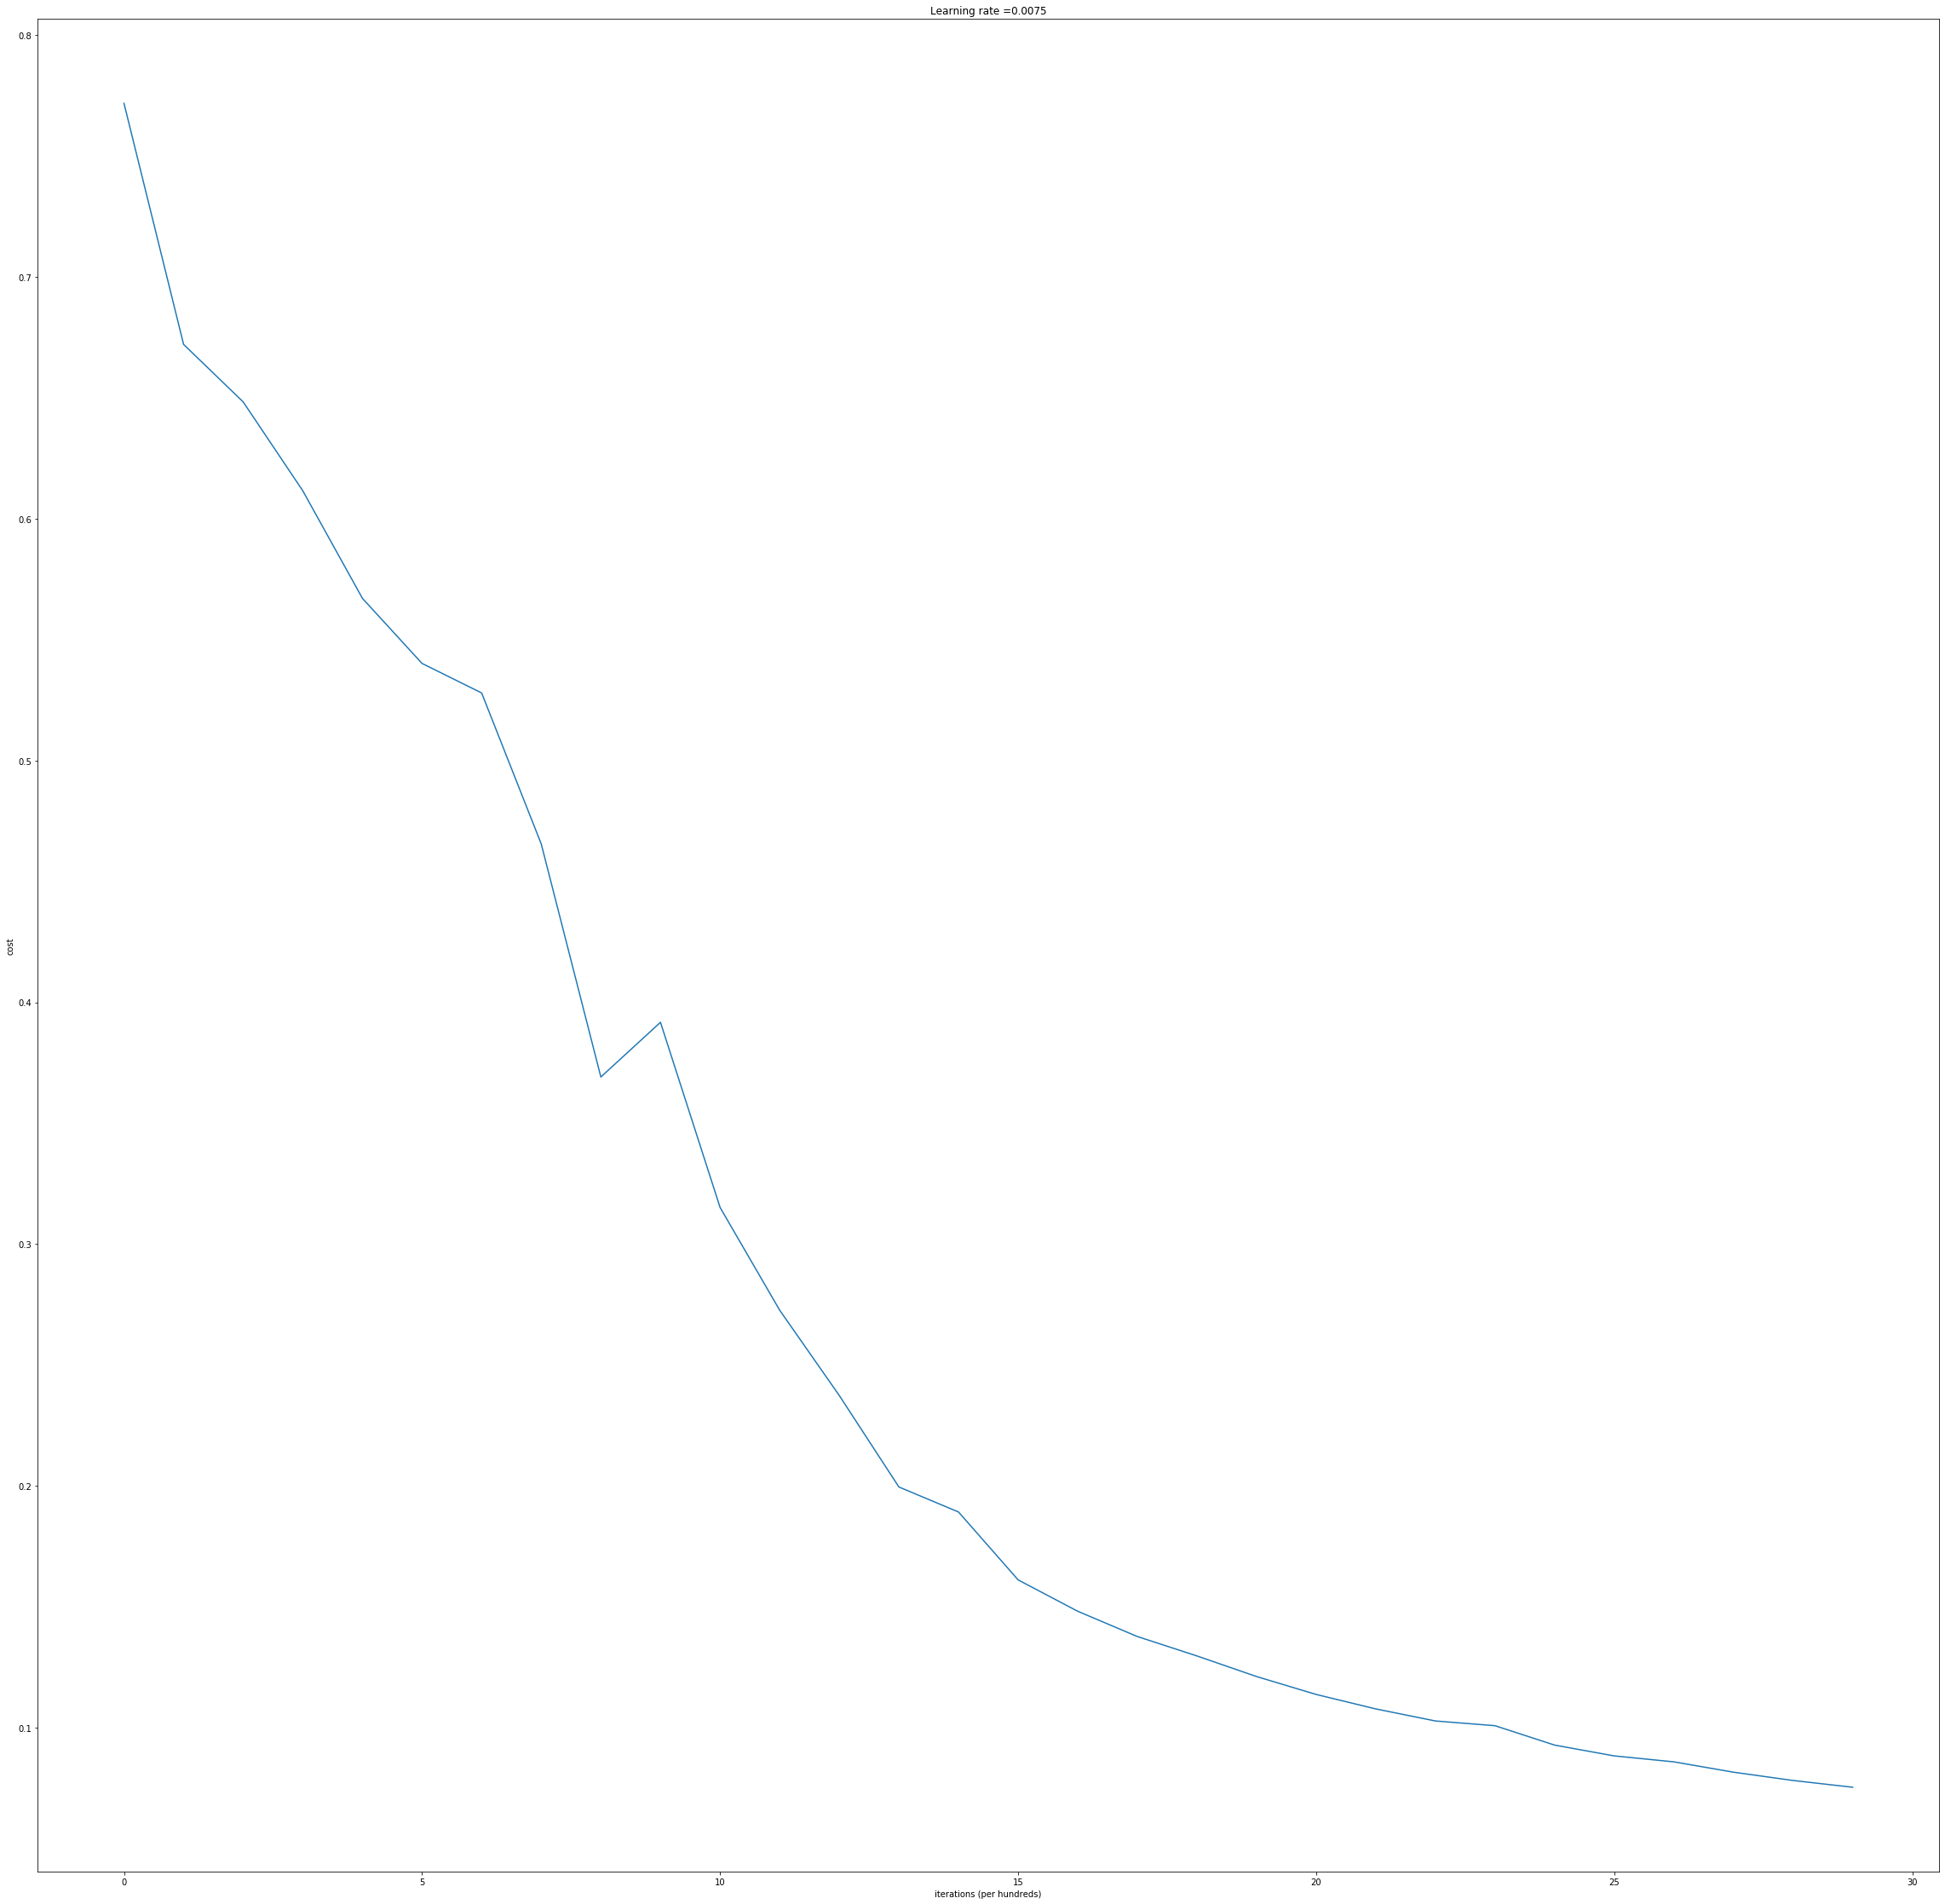

In [46]:
# network details 
layers_dims = [12288, 20, 7, 5, 1]
# layers_dims = [12288, 20, 10, 5, 3, 1] 

# Load data 
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Feature normalization.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

# run the model
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 3000, print_cost = True)

# Prediction 

In [43]:
# Predict function that will does prediction on new image.

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X : a new input image.
    parameters : trained model parameters.
    
    Returns:
    p : predictions.
    """
    
    m = X.shape[1]
    # number of layers in the neural network
    n = len(parameters) // 2 
    # initializing probability values for input data.
    p = np.zeros((1,m))
    
    # We use L_model_forward function to do the prediction.
    # this is done because, after training the data, we believe that the weight values are at its optimum values.
    # and the model is ready for doing prediction.
    probas, caches = L_model_forward(X, parameters)

    
    # convert probabilities, probas to 0-1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

# we can check which data were mislabeled 

def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X : dataset
    y : true labels
    p : predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

In [44]:
# predict training accuracy
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [45]:
# predict test accuracy
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.78


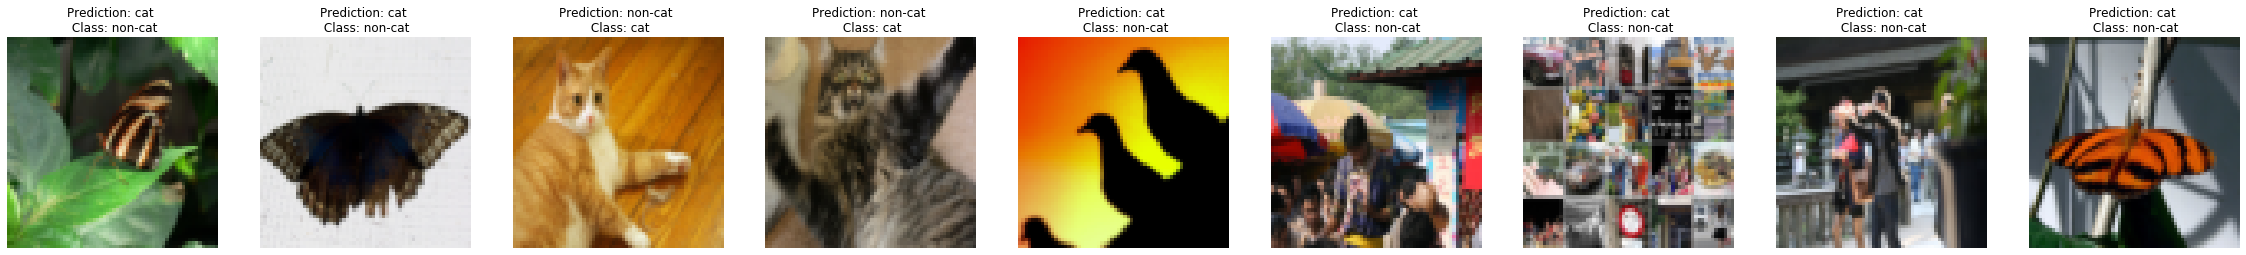

In [31]:
# print mislebeled data.
print_mislabeled_images(classes, test_x, test_y, pred_test)